In [2]:
import biographs as bg

In [3]:
pip install biographs wget

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install pydssp

Note: you may need to restart the kernel to use updated packages.


In [5]:
import wget
import os
#download an example pdb file
url = 'https://files.rcsb.org/download/1EEI.pdb'
filename = wget.download(url)
print(filename)

1eei (2).pdb


[<Chain id=D>, <Chain id=E>, <Chain id=F>, <Chain id=G>, <Chain id=H>] 181
[[<Residue THR het=  resseq=1 icode= >, <Residue PRO het=  resseq=2 icode= >, <Residue GLN het=  resseq=3 icode= >, <Residue ASN het=  resseq=4 icode= >], [<Residue PRO het=  resseq=2 icode= >, <Residue GLN het=  resseq=3 icode= >, <Residue ASN het=  resseq=4 icode= >, <Residue ILE het=  resseq=5 icode= >], [<Residue GLN het=  resseq=3 icode= >, <Residue ASN het=  resseq=4 icode= >, <Residue ILE het=  resseq=5 icode= >, <Residue THR het=  resseq=6 icode= >], [<Residue ASN het=  resseq=4 icode= >, <Residue ILE het=  resseq=5 icode= >, <Residue THR het=  resseq=6 icode= >, <Residue ASP het=  resseq=7 icode= >], [<Residue ILE het=  resseq=5 icode= >, <Residue THR het=  resseq=6 icode= >, <Residue ASP het=  resseq=7 icode= >, <Residue LEU het=  resseq=8 icode= >], [<Residue THR het=  resseq=6 icode= >, <Residue ASP het=  resseq=7 icode= >, <Residue LEU het=  resseq=8 icode= >, <Residue CYS het=  resseq=9 icode= >], 

/home/cacutskid/miniconda3/envs/ml2/lib/python3.11/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 4488.
  warnings.warn(
/home/cacutskid/miniconda3/envs/ml2/lib/python3.11/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain E is discontinuous at line 4509.
  warnings.warn(
/home/cacutskid/miniconda3/envs/ml2/lib/python3.11/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain F is discontinuous at line 4530.
  warnings.warn(
/home/cacutskid/miniconda3/envs/ml2/lib/python3.11/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain G is discontinuous at line 4551.
  warnings.warn(
/home/cacutskid/miniconda3/envs/ml2/lib/python3.11/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain H is discontinuous at line 4572.
  warnings.warn(
/home/cacutskid/miniconda3/envs/ml2/lib/python3.11/site-packages/Bio/P

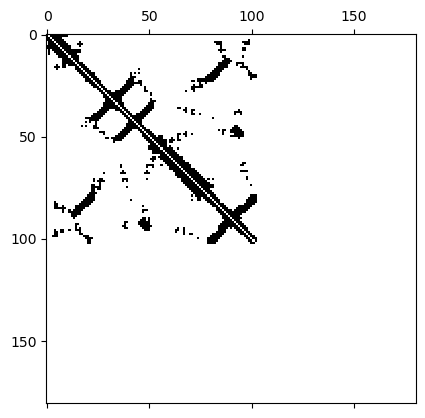

In [56]:
#a function to read the pdb file and split it into individual chains using biopython    
from Bio import PDB

import warnings
    
def read_pdb(filename):
    #silence the biopython warnings
    with warnings.catch_warnings():        
        parser = PDB.PDBParser()
        structure = parser.get_structure(filename, filename)
        chains = [ c for c in structure.get_chains()]
        return chains

#return the phi, psi, and omega angles for each residue in a chain
def get_angles(chain):

    phi_psi_angles = []

    chain = [ r for r in chain if PDB.is_aa(r)]
    #sliding window of 3 residues
    polypeptides = [ chain[i:i+4] for i in range(len(chain)) if len(chain[i:i+4]) >= 3]
    print(polypeptides)
    for poly_index, poly in enumerate(polypeptides):
        phi = None
        psi = None

        if len(poly) >= 3:
            c_minus_1 = poly[len(poly) - 3]["C"].get_vector()
            n = poly[len(poly) - 2]["N"].get_vector()
            ca = poly[len(poly) - 2]["CA"].get_vector()
            c = poly[len(poly) - 2]["C"].get_vector()
            n_plus_1 = poly[len(poly) - 1]["N"].get_vector()

            # Calculate phi angle
            phi = PDB.calc_dihedral(c_minus_1, n, ca, c)

        if len(poly) >= 4:
            n = poly[len(poly) - 3]["N"].get_vector()
            ca = poly[len(poly) - 3]["CA"].get_vector()
            c = poly[len(poly) - 3]["C"].get_vector()
            n_plus_1 = poly[len(poly) - 2]["N"].get_vector()
            ca_plus_1 = poly[len(poly) - 1]["CA"].get_vector()

            # Calculate psi angle
            psi = PDB.calc_dihedral(n, ca, c, n_plus_1)

        residue = poly[0]
        residue_id = residue.get_full_id()

        phi_psi_angles.append({
            "Chain": residue_id[2],
            "Residue Number": residue_id[3][1],
            "Residue Name": residue.get_resname(),
            "Phi Angle": phi,
            "Psi Angle": psi
        })
    return phi_psi_angles

#return the contact points below a certain angstrom distance as edges in the graph
#use the biopython pairwise distance between alpha carbons
def get_contact_points(chain, distance):
    contact_mat = np.zeros((len(chain), len(chain)))
    for i,r1 in enumerate(chain):
        for j,r2 in enumerate(chain):
            if i< j:
                if 'CA' in r1 and 'CA' in r2:
                    if r1['CA'] - r2['CA'] < distance:
                        contact_mat[i,j] =  r1['CA'] - r2['CA']
    contact_mat = contact_mat + contact_mat.T
    return contact_mat


#test functions

chains = read_pdb(filename)
print(chains, len(chains[0]))

angles = get_angles(chains[0])
print(angles)
contact_points = get_contact_points(chains[0], 10)
print(contact_points)
plt.spy(contact_points)
plt.show()



torch.Size([1, 181, 5, 3])


/home/cacutskid/miniconda3/envs/ml2/lib/python3.11/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 4488.
  warnings.warn(
/home/cacutskid/miniconda3/envs/ml2/lib/python3.11/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain E is discontinuous at line 4509.
  warnings.warn(
/home/cacutskid/miniconda3/envs/ml2/lib/python3.11/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain F is discontinuous at line 4530.
  warnings.warn(
/home/cacutskid/miniconda3/envs/ml2/lib/python3.11/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain G is discontinuous at line 4551.
  warnings.warn(
/home/cacutskid/miniconda3/envs/ml2/lib/python3.11/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain H is discontinuous at line 4572.
  warnings.warn(
/home/cacutskid/miniconda3/envs/ml2/lib/python3.11/site-packages/Bio/P

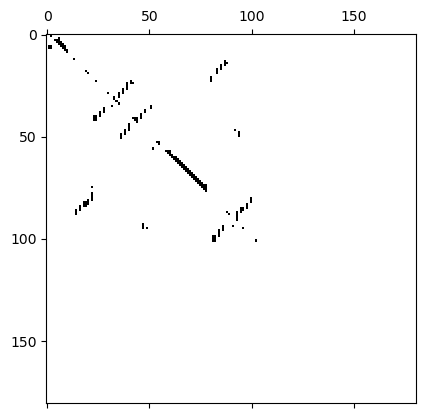

torch.Size([181, 181])
tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0324,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ...,    nan,    nan, 0.0000],
        [0.0000, 0.0000, 0.0000,  ...,    nan,    nan, 0.0000],
        [0.0000, 0.0000, 0.0000,  ...,    nan,    nan, 0.0000]],
       dtype=torch.float64)
torch.Size([1, 199, 5, 3])


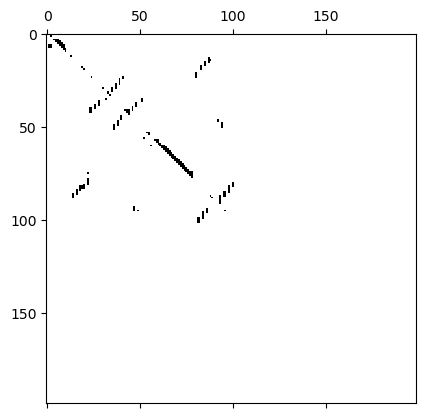

torch.Size([199, 199])
tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0333,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ...,    nan,    nan, 0.0000],
        [0.0000, 0.0000, 0.0000,  ...,    nan,    nan, 0.0000],
        [0.0000, 0.0000, 0.0000,  ...,    nan,    nan, 0.0000]],
       dtype=torch.float64)
torch.Size([1, 189, 5, 3])


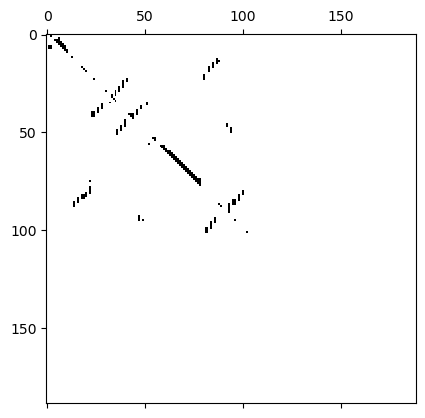

torch.Size([189, 189])
tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0322,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ...,    nan,    nan, 0.0000],
        [0.0000, 0.0000, 0.0000,  ...,    nan,    nan, 0.0000],
        [0.0000, 0.0000, 0.0000,  ...,    nan,    nan, 0.0000]],
       dtype=torch.float64)
torch.Size([1, 211, 5, 3])


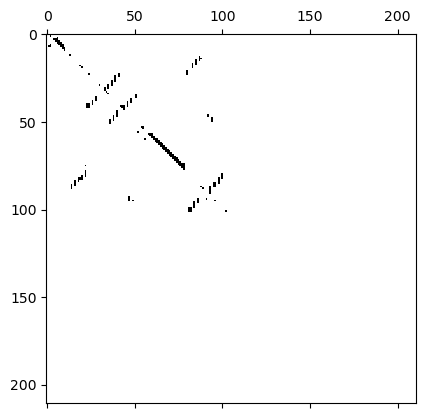

torch.Size([211, 211])
tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0329,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ...,    nan,    nan, 0.0000],
        [0.0000, 0.0000, 0.0000,  ...,    nan,    nan, 0.0000],
        [0.0000, 0.0000, 0.0000,  ...,    nan,    nan, 0.0000]],
       dtype=torch.float64)
torch.Size([1, 195, 5, 3])


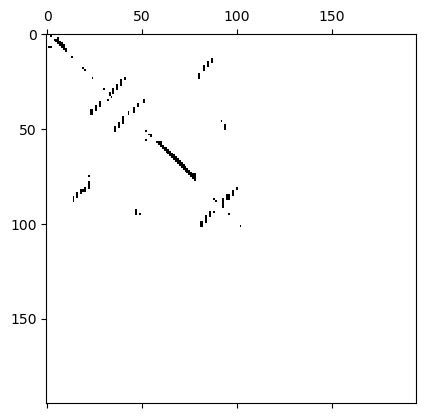

torch.Size([195, 195])
tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0334,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ...,    nan,    nan, 0.0000],
        [0.0000, 0.0000, 0.0000,  ...,    nan,    nan, 0.0000],
        [0.0000, 0.0000, 0.0000,  ...,    nan,    nan, 0.0000]],
       dtype=torch.float64)
{<Chain id=D>: tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0324,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ...,    nan,    nan, 0.0000],
        [0.0000, 0.0000, 0.0000,  ...,    nan,    nan, 0.0000],
        [0.0000, 0.0000, 0.0000,  ...,    nan,    nan, 0.0000]],
       dtype=torch.float64), <Chain id=E>: tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0333

In [29]:
# Import
import torch
import pydssp
from Bio.PDB import PDBParser   
import numpy as np
import matplotlib.pyplot as plt

# Sample coordinates
batch, length, atoms, xyz = 10, 100, 4, 3
## atoms should be 4 (N, CA, C, O) or 5 (N, CA, C, O, H)
typeindex = {'N':0, 'CA':1, 'C':2, 'O':3, 'H':4}

def ret_hbonds(filename):
    #loop through all atoms in a structure
    struct = PDBParser().get_structure('1eei', filename)
    mats = {}
    for i, model in enumerate(struct):
        for chain in model:
            #get the number of atoms in the chain
            #create a numpy array of zeros with the shape of (1, length, atoms, xyz)
            output = np.zeros((1, len(chain), len(typeindex), 3 ))
            for c, res in enumerate(chain):
                atoms = res.get_atoms()
                for at,atom in enumerate(atoms):
                    if atom.get_name() in typeindex:
                        output[ 0, c ,  typeindex[atom.get_name()] , : ]  = atom.get_coord()
            output = torch.tensor(output)
            print(output.shape)
            mats[chain] =  pydssp.get_hbond_map(output[0])
            plt.spy(mats[chain])
            plt.show()
            print(mats[chain].shape)
            print(mats[chain])

    return mats

mats = ret_hbonds(filename)
print(mats)

In [3]:
import pandas as pd
aaproperties = pd.read_csv('./aaindex1.csv')
print(aaproperties)
def feat_engg(seqdata):
    # Feature Engineering for the whole graph with summary properties of the protein
    data['protein_seq_len'] = data['protein_sequence'].str.len()
    data['protein_analysis_obj'] = data['protein_sequence'].apply(lambda x:ProteinAnalysis(x))
    data['protein_sequence_obj'] = data['protein_analysis_obj'].apply(lambda x: x.sequence)
    data['protein_molecular_weight'] = data['protein_analysis_obj'].apply(lambda x:x.molecular_weight())
    data['protein_aromaticity'] = data['protein_analysis_obj'].apply(lambda x:x.aromaticity())
    data['protein_charge_at_ph7'] = data['protein_analysis_obj'].apply(lambda x: round(x.charge_at_pH(pH=7),2))
    data['protein_gravy_val'] = data['protein_analysis_obj'].apply(lambda x: x.gravy())
    data['protein_isoelectric_point'] = data['protein_analysis_obj'].apply(lambda x: x.isoelectric_point())
    amino_acids_codes = [alpha for alpha in string.ascii_uppercase if alpha not in ['J', 'O', 'U', 'X']]
    for code in amino_acids_codes:
        data[f'amino_count_{code}'] = data['protein_sequence_obj'].apply(lambda x:x.count(code))
        data[f'amino_freq_{code}'] = data[f'amino_count_{code}']/data['protein_seq_len']
    return df

def ret_AA_vec(sequence, props):
    seqdf = pd.concat([ props[aa] if aa in props.columns else d = pd.DataFrame(0, index=np.arange(len(props)), columns=['null'])
 for aa in sequence.upper() ] , axis = 1)
    return seqdf




         A       R       N       D       C       Q       E     G       H  \
0     4.35   4.380   4.750   4.760   4.650   4.370   4.290  3.97   4.630   
1     0.61   0.600   0.060   0.460   1.070   0.000   0.470  0.07   0.610   
2     1.18   0.200   0.230   0.050   1.890   0.720   0.110  0.49   0.310   
3     1.56   0.450   0.270   0.140   1.230   0.510   0.230  0.62   0.290   
4     1.00   0.520   0.350   0.440   0.060   0.440   0.730  0.35   0.600   
..     ...     ...     ...     ...     ...     ...     ...   ...     ...   
561   6.00   5.000   6.600   6.800   9.330   6.500   6.670  3.50   4.700   
562  12.00  23.343  27.708  28.634  28.000  27.831  28.731  7.00  24.243   
563   0.00   0.000   0.000   0.000   0.000   0.000   0.000  0.00  -1.734   
564   6.00  10.667  10.000  10.400  11.333  10.500  10.667  3.50  10.400   
565   0.00   4.200   3.000   2.969   6.000   1.849   1.822  0.00   1.605   

          I  ...       M       F      P       S       T       W       Y  \
0     3.950 

In [18]:
#load the pdb file into a biographs molecule object
help(bg)

molecule = bg.Pmolecule(filename  )
help(molecule)
print(molecule)



Help on package biographs:

NAME
    biographs

PACKAGE CONTENTS
    classes (package)
    lib (package)

FILE
    /home/cacutskid/miniconda3/envs/ml2/lib/python3.11/site-packages/biographs/__init__.py


Help on Pmolecule in module biographs.classes.pmolecule object:

class Pmolecule(builtins.object)
 |  Pmolecule(structure_file, water=False)
 |  
 |  Create a Pmolecule object.
 |  
 |  The Pmolecule calls a number of methods for the analysis of protein
 |  structure. This includes the contruction of the interaction network of the
 |  protein.
 |  
 |  Parameters
 |  ----------
 |  structure_file : str
 |      The path to the structure file of the targeted protein. Three
 |      structure-file formats are supported: `pdb', `cif', and `ent'.
 |  water : boolean, (default: False)
 |      If False, water molecules are removed.
 |  
 |  Attributes
 |  ----------
 |  model: Bio.PDB.model
 |      The structural model of the structure. See www.biopython.org.
 |  network: networkx:Graph
 |    

In [27]:
#print attributes of the nodes in the graph

print(molecule)
print([ n for n in molecule.network(weight = True , cutoff= 8 ).nodes(data = True) ][0:10])
print([ e for e in molecule.network(weight = True , cutoff= 8 ).edges(data = True) ][0:10])



[('D1', {}), ('D2', {}), ('D3', {}), ('D4', {}), ('D5', {}), ('D6', {}), ('D7', {}), ('D8', {}), ('D9', {}), ('D10', {})]
[('D1', 'D11', {}), ('D1', 'E35', {}), ('D1', 'E37', {}), ('D1', 'D2', {}), ('D1', 'D3', {}), ('D1', 'E93', {}), ('D1', 'E92', {}), ('D1', 'E49', {}), ('D1', 'D8', {}), ('D1', 'E39', {})]


<class 'method'>


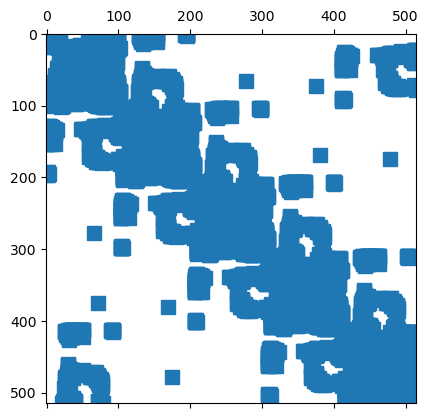

In [28]:
#molecule.network is a networkx graph object
print(type(molecule.network))
#create adjacency matrix from the networkx graph object
adj = nx.adjacency_matrix(molecule.network(weight = True , cutoff= 8 ))
#plot the adjacency matrix
plt.spy(adj)

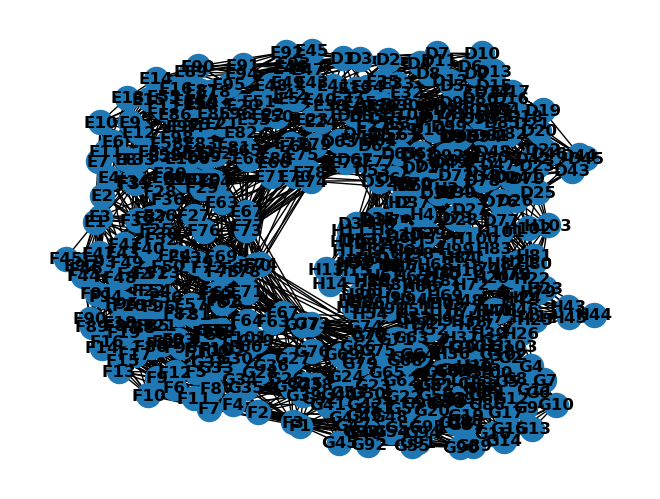

In [21]:
import networkx as nx
import matplotlib.pyplot as plt

#draw the networkx graph attribute of the molecule object
#show different node types in different colors

nx.draw(molecule.network(weight = True , cutoff= 8), with_labels=True, font_weight='bold')
plt.show()

In [ ]:
! pip install "torch-cluster" "pytorch-lightning>=1.4, <2.0.0" "torch-geometric" "torch-spline-conv" "lightning>=2.0.0rc0" "torch>=1.8.1, <1.14.0" "torch-sparse" "torch-scatter" "torchmetrics>=0.7, <0.12" 

In [ ]:
# Standard libraries
import os

# For downloading pre-trained models
import urllib.request
from urllib.error import HTTPError

# PyTorch Lightning
import lightning as L

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# PyTorch geometric
import torch_geometric
import torch_geometric.data as geom_data
import torch_geometric.nn as geom_nn

# PL callbacks
from lightning.pytorch.callbacks import ModelCheckpoint
from torch import Tensor

AVAIL_GPUS = min(1, torch.cuda.device_count())
BATCH_SIZE = 256 if AVAIL_GPUS else 64
# Path to the folder where the datasets are/should be downloaded
DATASET_PATH = os.environ.get("PATH_DATASETS", "data/")
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = os.environ.get("PATH_CHECKPOINT", "saved_models/GNNs/")

# Setting the seed
L.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [ ]:
class MLPModel(nn.Module):
    def __init__(self, c_in, c_hidden, c_out, num_layers=2, dp_rate=0.1):
        """
        Args:
            c_in: Dimension of input features
            c_hidden: Dimension of hidden features
            c_out: Dimension of the output features. Usually number of classes in classification
            num_layers: Number of hidden layers
            dp_rate: Dropout rate to apply throughout the network
        """
        super().__init__()
        layers = []
        in_channels, out_channels = c_in, c_hidden
        for l_idx in range(num_layers - 1):
            layers += [nn.Linear(in_channels, out_channels), nn.ReLU(inplace=True), nn.Dropout(dp_rate)]
            in_channels = c_hidden
        layers += [nn.Linear(in_channels, c_out)]
        self.layers = nn.Sequential(*layers)

    def forward(self, x, *args, **kwargs):
        """
        Args:
            x: Input features per node
        """
        return self.layers(x)

In [ ]:
class NodeLevelGNN(L.LightningModule):
    def __init__(self, model_name, **model_kwargs):
        super().__init__()
        # Saving hyperparameters
        self.save_hyperparameters()

        if model_name == "MLP":
            self.model = MLPModel(**model_kwargs)
        else:
            self.model = GNNModel(**model_kwargs)
        self.loss_module = nn.CrossEntropyLoss()

    def forward(self, data, mode="train"):
        x, edge_index = data.x, data.edge_index
        x = self.model(x, edge_index)

        # Only calculate the loss on the nodes corresponding to the mask
        if mode == "train":
            mask = data.train_mask
        elif mode == "val":
            mask = data.val_mask
        elif mode == "test":
            mask = data.test_mask
        else:
            assert False, "Unknown forward mode: %s" % mode

        loss = self.loss_module(x[mask], data.y[mask])
        acc = (x[mask].argmax(dim=-1) == data.y[mask]).sum().float() / mask.sum()
        return loss, acc

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=0.1, weight_decay=2e-3)
        return optimizer

    def training_step(self, batch, batch_idx):
        loss, acc = self.forward(batch, mode="train")
        self.log("train_loss", loss)
        self.log("train_acc", acc)
        return loss

    def validation_step(self, batch, batch_idx):
        _, acc = self.forward(batch, mode="val")
        self.log("val_acc", acc)

    def test_step(self, batch, batch_idx):
        _, acc = self.forward(batch, mode="test")
        self.log("test_acc", acc)
    

In [ ]:
def train_node_classifier(model_name, dataset, **model_kwargs):
    L.seed_everything(42)


    node_data_loader = geom_data.DataLoader(dataset, batch_size=1)

    # Create a PyTorch Lightning trainer
    root_dir = os.path.join(CHECKPOINT_PATH, "NodeLevel" + model_name)
    os.makedirs(root_dir, exist_ok=True)
    trainer = L.Trainer(
        default_root_dir=root_dir,
        callbacks=[ModelCheckpoint(save_weights_only=True, mode="max", monitor="val_acc")],
        accelerator="auto",
        devices=AVAIL_GPUS,
        max_epochs=200,
        enable_progress_bar=False,
    )  # 0 because epoch size is 1
    trainer.logger._default_hp_metric = None  # Optional logging argument that we don't need



    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(CHECKPOINT_PATH, "NodeLevel%s.ckpt" % model_name)
    if os.path.isfile(pretrained_filename):
        print("Found pretrained model, loading...")
        model = NodeLevelGNN.load_from_checkpoint(pretrained_filename)
    else:
        L.seed_everything()
        model = NodeLevelGNN(
            model_name=model_name, c_in=dataset.num_node_features, c_out=dataset.num_classes, **model_kwargs
        )
        trainer.fit(model, node_data_loader, node_data_loader)
        model = NodeLevelGNN.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)

    # Test best model on the test set
    test_result = trainer.test(model, dataloaders=node_data_loader, verbose=False)
    batch = next(iter(node_data_loader))
    batch = batch.to(model.device)
    _, train_acc = model.forward(batch, mode="train")
    _, val_acc = model.forward(batch, mode="val")
    result = {"train": train_acc, "val": val_acc, "test": test_result[0]["test_acc"]}
    return model, result

In [ ]:


import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv , SAGEConv , TransformerConv, GATConv
from torch import ModuleDict



#import lightning
import pytorch_lightning as pl
from pytorch_lightning import Trainer
#geometric lightning
from torch_geometric.data import DataLoader


from torch_geometric.data import Data


# Define autoencoder model
class Autoencoder(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, encoder_layers, decoder_layers):
        super(Autoencoder, self).__init__()


        #adaptive pooling of neighbors

        pooling = 'adaptive_avg_pool1d'

        #module dictionary
        self.encoder = ModuleDict()
        self.decoder = ModuleDict()
        
        
        
        #make hourglass
        encoder_layers = 3
        decoder_layers = 3

        delta_encoder = int((in_channels - hidden_channels) / encoder_layers)
        delta_decoder = int((hidden_channels - in_channels) / decoder_layers)

        hidden_channels_encoder = []
        hidden_channels_decoder = []
        
        
        
        for l in range(encoder_layers) :
            if l == 0 :
                hidden_channels_encoder.append(in_channels)
            else :
                hidden_channels_encoder.append(int(l*delta))
        
        for l in range(decoder_layers) :
            if l == 0 :
                hidden_channels_encoder.append(in_channels)
            else :
                hidden_channels_encoder.append(int(l*delta))
        


        self.encoder = GCNConv(in_channels, hidden_channels)
        self.decoder = GCNConv(hidden_channels, in_channels)

    def forward(self, x, edge_index):
        z = F.relu(self.encoder(x, edge_index))
        x_hat = self.decoder(z, edge_index)
        return z, x_hat

# Instantiate model and optimizer
model = Autoencoder(dataset.num_node_features, 16)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Train model
model.train()
for epoch in range(200):
    optimizer.zero_grad()
    z, x_hat = model(dataset.x, dataset.edge_index)
    loss = F.mse_loss(x_hat, dataset.x)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print('Epoch: {:03d}, Loss: {:.4f}'.format(epoch, loss.item()))

# Extract node embeddings
model.eval()
with torch.no_grad():
    z, _ = model(dataset.x, dataset.edge_index)
node_embeddings = z.detach().cpu().numpy()

print('Node embeddings shape:', node_embeddings.shape)


